# CNN 과제 - 배세은

In [1]:
import os
import urllib.request
import tarfile
import torch
import random
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

## 1. Custom dataset class 구현

####**-   Oxford Pet Dataset의 특징**


1.   images와 annotations을 각각 url로 tar.gz 압축파일형식으로 받을 수 있음

2.   annotations 밑에 있는 trainval.txt와 test.txt파일에 이미지파일의 각 종의 클래스 label이 포함되어 있음

이런 특성을 활용해 두 파일을 모두 다운받아 custom dataset class로 처리를 해주어 각각 이미지와 label을 할당하는 과정을 거치게 되었습니다.

In [2]:
# 실험의 재현성을 위해 seed 고정
def set_seed(seed):
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

# 데이터셋 URL과 다운로드 경로
DATA_URL_IMAGES = "https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz"
DATA_URL_ANNOTATIONS = "https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz"
DATA_DIR = "./oxford_pets"

# 데이터 다운로드 및 압축 해제 함수
def download_and_extract_data(url, dest_dir, archive_name):
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)
    tar_path = os.path.join(dest_dir, archive_name)

    if not os.path.exists(tar_path):
        print(f"Downloading {archive_name}...")
        urllib.request.urlretrieve(url, tar_path)
        print("Download complete.")

    print(f"Extracting {archive_name}...")
    with tarfile.open(tar_path, "r:gz") as tar:
        tar.extractall(dest_dir)
    print("Extraction complete.")

# annotation 파일 로드 함수
def load_annotations(annotation_file):
    annotations = {}
    with open(annotation_file, "r") as f:
        for line in f.readlines(): # annotation file을 줄단위로 읽음
            parts = line.strip().split()
            filename = parts[0] + ".jpg"
            label = int(parts[1]) - 1  # 라벨은 1부터 시작하므로 0부터 시작하도록 조정해줌
            annotations[filename] = label
    return annotations

# Custom Dataset Class
class OxfordPetsDataset(Dataset):
    def __init__(self, data_path, annotations, transform=None):
        self.data_path = data_path
        self.annotations = annotations
        self.transform = transform
        self.images = list(annotations.keys())
        self.labels = list(annotations.values())

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = os.path.join(self.data_path, self.images[idx])
        label = self.labels[idx]
        image = Image.open(image_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label


# 데이터 준비
download_and_extract_data(DATA_URL_IMAGES, DATA_DIR, "images.tar.gz")
download_and_extract_data(DATA_URL_ANNOTATIONS, DATA_DIR, "annotations.tar.gz")

# 어노테이션 로드
trainval_file_path = os.path.join(DATA_DIR, "annotations", "trainval.txt")
test_file_path = os.path.join(DATA_DIR, "annotations", "test.txt")

trainval_annotations = load_annotations(trainval_file_path)
test_annotations = load_annotations(test_file_path)

Download complete.
Extracting images.tar.gz...
Extraction complete.
Download complete.
Extracting annotations.tar.gz...
Extraction complete.


In [3]:
# 이미지에 적용할 transform
transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

# trainval 데이터를 shuffle하여 9:1로 분할
trainval_keys = list(trainval_annotations.keys())
random.shuffle(trainval_keys)

train_size = int(0.9 * len(trainval_keys))
val_size = len(trainval_keys) - train_size

train_keys = trainval_keys[:train_size]
val_keys = trainval_keys[train_size:]

train_annotations = {key: trainval_annotations[key] for key in train_keys}
val_annotations = {key: trainval_annotations[key] for key in val_keys}

# 데이터셋 생성
train_dataset = OxfordPetsDataset(data_path=os.path.join(DATA_DIR, "images"), annotations=train_annotations, transform=transforms)
val_dataset = OxfordPetsDataset(data_path=os.path.join(DATA_DIR, "images"), annotations=val_annotations, transform=transforms)
test_dataset = OxfordPetsDataset(data_path=os.path.join(DATA_DIR, "images"), annotations=test_annotations, transform=transforms)

# DataLoader 생성, batch단위로 나눠주기
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

데이터셋 사이즈를 확인해본 결과 trainval set은 3680개의 굉장히 적은 양의 이미지로 이루어져 있는 것을 확인해볼 수 있었습니다.

In [4]:
print(f"Train Dataset size: {len(train_dataset)}")
print(f"Validation Dataset size: {len(val_dataset)}")
print(f"Test Dataset size: {len(test_dataset)}")

Train Dataset size: 3312
Validation Dataset size: 368
Test Dataset size: 3669


#2. Custom CNN model 구축
- ResNet을 basemodel로 사용하여서 skip-connection을 포함하였고 dropout과 batchnorm을 추가로 사용하였습니다.


In [5]:
# ResNet 기반 Residual Block 정의
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None, dropout_prob=0.5):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(p=dropout_prob)  # Dropout 레이어 추가

    def forward(self, x):
        identity = x
        if self.downsample:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out = self.dropout(out)  # Dropout 적용

        out += identity  # Skip connection
        out = self.relu(out)

        return out

# ResNet Custom 모델 정의
class CustomResNet(nn.Module):
    def __init__(self, num_classes=2, dropout_prob=0.5):
        super(CustomResNet, self).__init__()
        self.in_channels = 128  # 초기 in_channels를 128로 설정

        self.conv1 = nn.Conv2d(3, 128, kernel_size=7, stride=2, padding=3, bias=False)  # in_channels=128
        self.bn1 = nn.BatchNorm2d(128)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(128, 2, dropout_prob=dropout_prob)
        self.layer2 = self._make_layer(256, 2, stride=2, dropout_prob=dropout_prob)
        self.layer3 = self._make_layer(512, 2, stride=2, dropout_prob=dropout_prob)
        self.layer4 = self._make_layer(1024, 2, stride=2, dropout_prob=dropout_prob)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(1024, num_classes)  # 최종 out_channels=1024
        self.dropout = nn.Dropout(p=dropout_prob)  # Dropout 레이어 추가

    def _make_layer(self, out_channels, blocks, stride=1, dropout_prob=0.5):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        layers = []
        layers.append(ResidualBlock(self.in_channels, out_channels, stride, downsample, dropout_prob))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels, dropout_prob=dropout_prob))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)

        x = self.dropout(x)
        x = self.fc(x)

        return x


#3. Model Training
- LR schedular인 StepLR을 사용하여서 안정적인 학습을 위해 점차 학습률이 낮아지도록 하였습니다.
- class의 개수가 37개이므로 output개수를 37로 정하였습니다.
- train, valid set을 사용하여 동시에 학습 진행상황이 어떻
게 되는지 확인하였습니다.
- Early Stopping을 사용하여 valid set에 대해 성능향상이 일정 epoch 이상 오르지 않으면 학습을 멈추게 하였습니다.
- 학습 중간에 best model params를 저장하여 test set으로 평가시에 최고의 성능을 내는 파라미터로 평가하도록 하였습니다.

In [6]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

# 모델, 손실 함수, 옵티마이저 설정
model = CustomResNet(num_classes=37)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 학습률 스케줄러 설정 (StepLR 사용)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)  # step_size마다 lr을 gamma배로 감소시킴

# Training 함수
def train(model, loader, criterion, optimizer, device):
    model.train()
    total_loss, correct = 0, 0
    for batch_idx, (images, labels) in enumerate(loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()

    return total_loss / len(loader), correct / len(loader.dataset) * 100

# Validation 함수
def validate(model, loader, criterion, device):
    model.eval()
    total_loss, correct = 0, 0
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()

    return total_loss / len(loader), correct / len(loader.dataset) * 100

# Test 함수
def test(model, loader, device):
    model.load_state_dict(torch.load("cnn_best_model.pth", weights_only=True))
    model.eval()
    correct = 0
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            correct += (outputs.argmax(1) == labels).sum().item()

    accuracy = correct / len(loader.dataset) * 100
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

# 학습 루프
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 70
# Training 및 Validation 기록 저장
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

# early stopping
patience = 10
best_acc = 0
patience_counter = 0

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%")

    # Early stopping 체크
    if val_acc > best_acc:
        best_acc = val_acc
        patience_counter = 0
        torch.save(model.state_dict(), "cnn_best_model.pth")
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print("Early stopping")
        break

    # 학습률 스케줄러 업데이트
    scheduler.step()

# Test 데이터셋 평가
test_accuracy = test(model, test_loader, device)

Epoch 1/70
Train Loss: 3.9607, Train Accuracy: 3.62%
Validation Loss: 3.7581, Validation Accuracy: 8.42%
Epoch 2/70
Train Loss: 3.7062, Train Accuracy: 5.59%
Validation Loss: 3.4521, Validation Accuracy: 9.51%
Epoch 3/70
Train Loss: 3.5606, Train Accuracy: 6.70%
Validation Loss: 3.4002, Validation Accuracy: 6.25%
Epoch 4/70
Train Loss: 3.4676, Train Accuracy: 8.00%
Validation Loss: 3.5153, Validation Accuracy: 6.25%
Epoch 5/70
Train Loss: 3.4081, Train Accuracy: 9.48%
Validation Loss: 3.2056, Validation Accuracy: 12.23%
Epoch 6/70
Train Loss: 3.2871, Train Accuracy: 11.17%
Validation Loss: 3.3344, Validation Accuracy: 10.60%
Epoch 7/70
Train Loss: 3.1907, Train Accuracy: 12.62%
Validation Loss: 3.0812, Validation Accuracy: 15.49%
Epoch 8/70
Train Loss: 3.1193, Train Accuracy: 14.31%
Validation Loss: 3.0360, Validation Accuracy: 12.50%
Epoch 9/70
Train Loss: 3.0477, Train Accuracy: 14.89%
Validation Loss: 2.9037, Validation Accuracy: 17.93%
Epoch 10/70
Train Loss: 2.9345, Train Accuracy

##학습 결과 분석
- Early Stopping으로 39 epoch만 돌게 되었습니다.
- Train Accuracy는 43% 정도, Validation Accuracy는 30% 정도로 수렴하게 되었습니다.
- 최종 Test Accuracy는 25.10% 라는 낮은 결과가 나타나게 되었습니다.

#4. Training Log 시각화
- Accuracy가 학습 초반에는 Train Loss가 Validation Loss보다 진동하면서 낮게 나타나 Underfitting이 일어난 줄 알았으나 약 10 epoch 이상부터는 Valid Loss가 더 낮게 나타나 올바르게 학습됨을 알 수 있었습니다.
- 하지만 Train Accuracy도 약 40% 정도에 수렴하는 것을 보아서 학습하는 데이터도 잘 맞추지 못함을 볼 수 있었습니다.


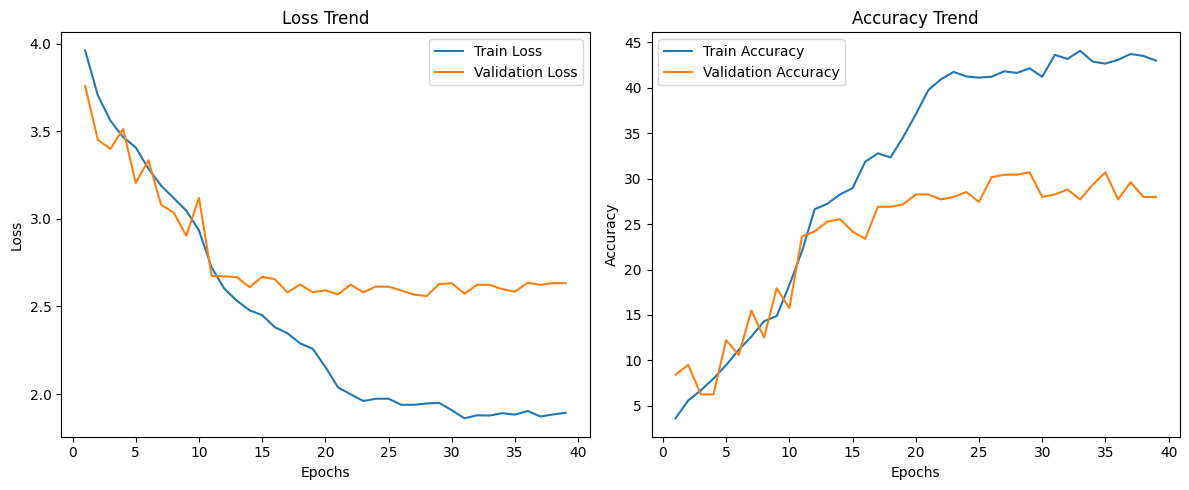

In [7]:
# 학습 및 검증 기록 시각화
plt.figure(figsize=(12, 5))

# Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Trend')
plt.legend()

# Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Trend')
plt.legend()

plt.tight_layout()
plt.show()

#5. 분석, 고찰 및 느낀점
- Train Accuracy는 데이터에 대해서 어느정도는 학습하였으나 충분히 최적화 되지 않았음을 보여줍니다.
- 모델의 성능이 잘 나오지 않았음에 대한 가장 큰 이유는 아마 데이터셋의 크기가 너무 작아서 충분히 학습하지 못했을 것이라고 예상됩니다.
- 향후 Data Augmentation을 추가하거나 모델의 복잡도를 줄이는 방향으로 다시 학습을 시켜보면 좋을 것 같습니다.